In [1]:
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to c:\users\g5\appdata\local\temp\pip-req-build-sd_v59bt
  Resolved https://github.com/tensorflow/examples.git to commit c92e03d9b3dc37028cc0a4538f372c89a15a4b93

  Running command git clone -q https://github.com/tensorflow/examples.git 'C:\Users\G5\AppData\Local\Temp\pip-req-build-sd_v59bt'


In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt


## Download the Oxford-IIIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+.

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In addition, the image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


The dataset already contains the required training and test splits, so continue to use the same splits:

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


The dataset already contains the required training and test splits, so continue to use the same splits:

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


The following class performs a simple augmentation by randomly-flipping an image. Go to the Image augmentation tutorial to learn more.

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


Build the input pipeline, applying the augmentation after batching the inputs:

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


Visualize an image example and its corresponding mask from the dataset:

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


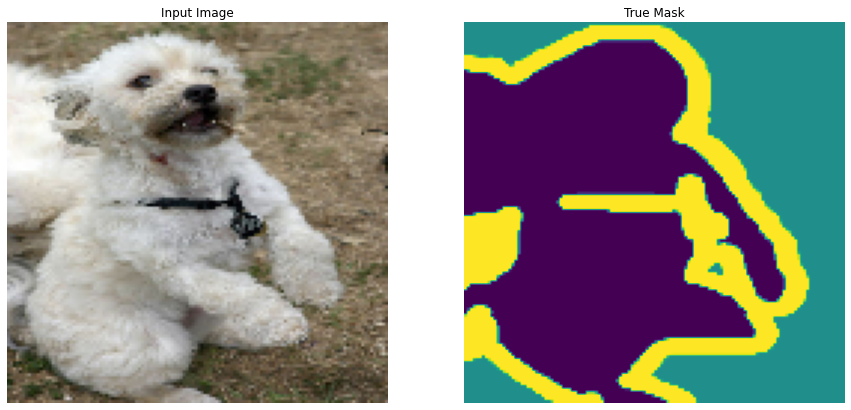

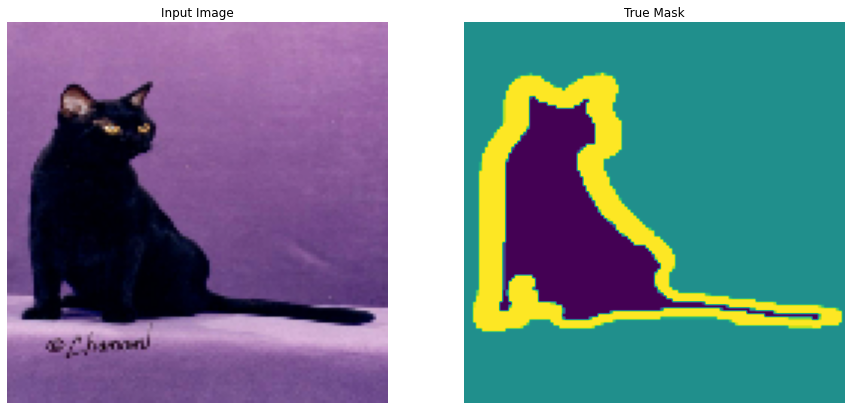

In [12]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


## Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the pix2pix: Image-to-image translation with a conditional GAN tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [15]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


Note that the number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the tf.keras.losses.CategoricalCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [16]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Plot the resulting model architecture:

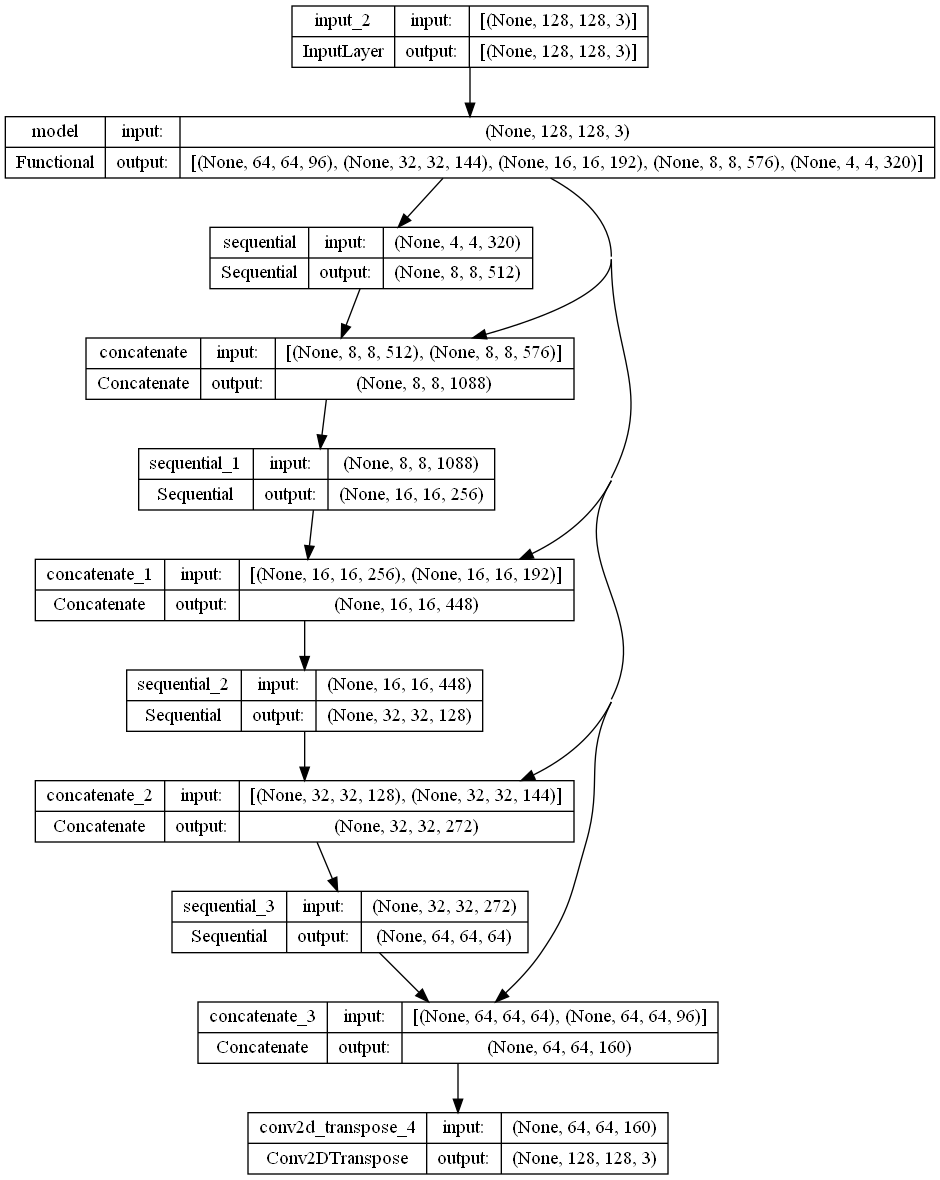

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)


Try out the model to check what it predicts before training:

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [20]:
show_predictions()


: 

: 